# Image Classification with Convolutional Neural Networks

이 예제에서는 텐서플로의 고급 API인 [tf.keras](https://www.tensorflow.org/guide/keras)를 사용하여 CNN을 구현하는 방법을 배운다.   

Fashion MNIST 데이터셋을 사용하여 이미지 분류기를 CNN으로 생성한다.

## Install and import dependencies

[TensorFlow Datasets](https://www.tensorflow.org/datasets/)를 사용하면 테스트 데이터를 손쉽게 다운로드하고 생성할 수 있다. 

In [1]:
!pip install -U tensorflow_datasets

Requirement already up-to-date: tensorflow_datasets in c:\users\aonek_000\anaconda3\lib\site-packages (1.0.2)


In [2]:
# Import TensorFlow and TensorFlow Datasets
import tensorflow as tf
import tensorflow_datasets as tfds
tf.logging.set_verbosity(tf.logging.ERROR)

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

# Improve progress bar display
import tqdm
import tqdm.auto
tqdm.tqdm = tqdm.auto.tqdm


print(tf.__version__)

# This will go away in the future.
# If this gives an error, you might be running TensorFlow 2 or above
# If so, the just comment out this line and run this cell again
tf.enable_eager_execution()  


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

1.13.1


## Import the Fashion MNIST dataset

10개의 범주(category)와 70,000개의 흑백 이미지로 구성된 패션 MNIST 데이터셋을 사용한다. 이미지는 해상도(28x28 픽셀)가 낮고 다음처럼 개별 옷 품목을 나타낸다.

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

60,000개의 훈련 images 와 10,000개의 테스트 images로 구성되어 있다. 

In [3]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

*training dataset* 와 *test dataset*로 나뉜다.

* The model is trained using `train_dataset`.
* The model is tested against `test_dataset`.


다음과 같이 10개의 class로 구성되어 있다.

In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

### Explore the data

데이터를 확인하자.

In [5]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


## Preprocess the data

데이터의 학습을 원할하게 하기 위해 range를 `[0,1]`로 정규화하자. 

In [6]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

### Explore the processed data

이미지를 출력해 보자.

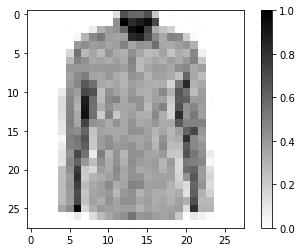

In [7]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

테스트 데이터 셋에서 25개의 데이터를 가져와 화면에 출력해 보자

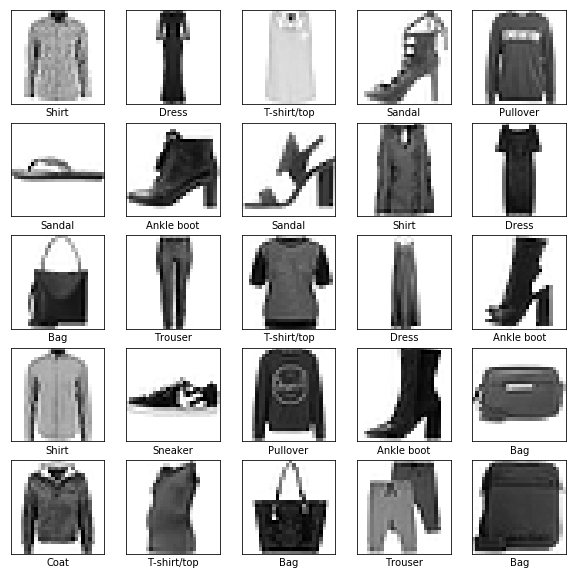

In [8]:
plt.figure(figsize=(10,10))
i = 0
for (image, label) in test_dataset.take(25):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
    i += 1
plt.show()

## Build the model

모델의 생성

### Setup the layers
CNN모형의 layer를 구성한다.

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])

* **"convolutions"** `tf.keras.layers.Conv2D and MaxPooling2D`

* **output** `tf.keras.layers.Dense` - 10-node의 output *softmax* layer로 클래스의 확률을 출력한다. 


### Compile the model


* *Loss function* — 분류에 맞도록 `sparse_categorical_crossentropy`
* *Optimizer* — loss를 최소화하도록 weight를 update한다.
* *Metrics* —training 과 testing steps을 모니터링한다. *accuracy*는 정확도를 출력한다.

In [10]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Train the model

train dataset iteration 과 관련된 다음 설정을 한다. :
1. `dataset.repeat()` (iteration 횟수는 batch_size에 의해 결정된다).
2. `dataset.shuffle(60000)` 훈련데이터를 섞어서 무작위 추출한다.
3. `dataset.batch(32)` batch_size를 지정한다.

In [11]:
BATCH_SIZE = 32
train_dataset = train_dataset.repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [12]:
# epoch size는 훈련 시간을 고려하여 적절히 선택한다.
model.fit(train_dataset, epochs=1, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

 296/1875 [===>..........................] - ETA: 3:15:05 - loss: 2.2948 - acc: 0.12 - ETA: 1:38:17 - loss: 2.2547 - acc: 0.17 - ETA: 1:06:06 - loss: 2.2098 - acc: 0.18 - ETA: 49:57 - loss: 2.1772 - acc: 0.2188 - ETA: 33:44 - loss: 2.1372 - acc: 0.22 - ETA: 29:09 - loss: 2.0984 - acc: 0.27 - ETA: 22:57 - loss: 2.0185 - acc: 0.31 - ETA: 19:01 - loss: 1.9249 - acc: 0.35 - ETA: 16:18 - loss: 1.8359 - acc: 0.37 - ETA: 15:14 - loss: 1.7987 - acc: 0.39 - ETA: 14:19 - loss: 1.7536 - acc: 0.40 - ETA: 13:32 - loss: 1.7099 - acc: 0.40 - ETA: 12:49 - loss: 1.6701 - acc: 0.41 - ETA: 12:12 - loss: 1.6543 - acc: 0.41 - ETA: 11:06 - loss: 1.5921 - acc: 0.43 - ETA: 10:13 - loss: 1.5432 - acc: 0.46 - ETA: 9:50 - loss: 1.5145 - acc: 0.4701 - ETA: 9:29 - loss: 1.4866 - acc: 0.477 - ETA: 8:51 - loss: 1.4301 - acc: 0.496 - ETA: 8:19 - loss: 1.3868 - acc: 0.512 - ETA: 7:51 - loss: 1.3534 - acc: 0.520 - ETA: 7:26 - loss: 1.3092 - acc: 0.533 - ETA: 7:05 - loss: 1.2776 - acc: 0.543 - ETA: 6:55 - loss: 1.2582 -

 523/1875 [=======>......................] - ETA: 1:49 - loss: 0.6331 - acc: 0.773 - ETA: 1:49 - loss: 0.6323 - acc: 0.773 - ETA: 1:49 - loss: 0.6310 - acc: 0.773 - ETA: 1:48 - loss: 0.6296 - acc: 0.774 - ETA: 1:48 - loss: 0.6289 - acc: 0.774 - ETA: 1:48 - loss: 0.6292 - acc: 0.774 - ETA: 1:48 - loss: 0.6286 - acc: 0.774 - ETA: 1:48 - loss: 0.6277 - acc: 0.774 - ETA: 1:48 - loss: 0.6278 - acc: 0.774 - ETA: 1:47 - loss: 0.6281 - acc: 0.774 - ETA: 1:47 - loss: 0.6273 - acc: 0.775 - ETA: 1:47 - loss: 0.6266 - acc: 0.775 - ETA: 1:47 - loss: 0.6263 - acc: 0.775 - ETA: 1:47 - loss: 0.6253 - acc: 0.775 - ETA: 1:46 - loss: 0.6238 - acc: 0.776 - ETA: 1:46 - loss: 0.6218 - acc: 0.777 - ETA: 1:46 - loss: 0.6208 - acc: 0.777 - ETA: 1:46 - loss: 0.6200 - acc: 0.778 - ETA: 1:46 - loss: 0.6197 - acc: 0.778 - ETA: 1:45 - loss: 0.6189 - acc: 0.778 - ETA: 1:45 - loss: 0.6178 - acc: 0.778 - ETA: 1:45 - loss: 0.6173 - acc: 0.778 - ETA: 1:45 - loss: 0.6168 - acc: 0.778 - ETA: 1:45 - loss: 0.6169 - acc: 0.7

 739/1875 [==========>...................] - ETA: 1:24 - loss: 0.5402 - acc: 0.807 - ETA: 1:24 - loss: 0.5398 - acc: 0.807 - ETA: 1:24 - loss: 0.5399 - acc: 0.807 - ETA: 1:24 - loss: 0.5391 - acc: 0.807 - ETA: 1:24 - loss: 0.5388 - acc: 0.808 - ETA: 1:24 - loss: 0.5384 - acc: 0.808 - ETA: 1:24 - loss: 0.5382 - acc: 0.808 - ETA: 1:24 - loss: 0.5378 - acc: 0.808 - ETA: 1:24 - loss: 0.5378 - acc: 0.808 - ETA: 1:24 - loss: 0.5371 - acc: 0.808 - ETA: 1:24 - loss: 0.5370 - acc: 0.808 - ETA: 1:23 - loss: 0.5367 - acc: 0.808 - ETA: 1:23 - loss: 0.5367 - acc: 0.808 - ETA: 1:23 - loss: 0.5360 - acc: 0.808 - ETA: 1:23 - loss: 0.5350 - acc: 0.808 - ETA: 1:23 - loss: 0.5348 - acc: 0.809 - ETA: 1:23 - loss: 0.5345 - acc: 0.809 - ETA: 1:23 - loss: 0.5339 - acc: 0.809 - ETA: 1:23 - loss: 0.5339 - acc: 0.809 - ETA: 1:23 - loss: 0.5339 - acc: 0.809 - ETA: 1:23 - loss: 0.5333 - acc: 0.809 - ETA: 1:23 - loss: 0.5327 - acc: 0.809 - ETA: 1:22 - loss: 0.5321 - acc: 0.810 - ETA: 1:22 - loss: 0.5321 - acc: 0.8

 956/1875 [==============>...............] - ETA: 1:14 - loss: 0.4918 - acc: 0.823 - ETA: 1:14 - loss: 0.4917 - acc: 0.823 - ETA: 1:14 - loss: 0.4918 - acc: 0.823 - ETA: 1:14 - loss: 0.4915 - acc: 0.823 - ETA: 1:14 - loss: 0.4914 - acc: 0.823 - ETA: 1:14 - loss: 0.4911 - acc: 0.823 - ETA: 1:14 - loss: 0.4910 - acc: 0.823 - ETA: 1:14 - loss: 0.4906 - acc: 0.823 - ETA: 1:14 - loss: 0.4905 - acc: 0.823 - ETA: 1:14 - loss: 0.4903 - acc: 0.823 - ETA: 1:14 - loss: 0.4901 - acc: 0.823 - ETA: 1:14 - loss: 0.4900 - acc: 0.823 - ETA: 1:13 - loss: 0.4900 - acc: 0.823 - ETA: 1:13 - loss: 0.4901 - acc: 0.823 - ETA: 1:13 - loss: 0.4900 - acc: 0.823 - ETA: 1:13 - loss: 0.4899 - acc: 0.823 - ETA: 1:13 - loss: 0.4892 - acc: 0.824 - ETA: 1:13 - loss: 0.4885 - acc: 0.824 - ETA: 1:13 - loss: 0.4884 - acc: 0.824 - ETA: 1:13 - loss: 0.4882 - acc: 0.824 - ETA: 1:13 - loss: 0.4880 - acc: 0.824 - ETA: 1:12 - loss: 0.4880 - acc: 0.824 - ETA: 1:12 - loss: 0.4874 - acc: 0.824 - ETA: 1:12 - loss: 0.4872 - acc: 0.8

1185/1875 [=================>............] - ETA: 1:02 - loss: 0.4595 - acc: 0.835 - ETA: 1:02 - loss: 0.4593 - acc: 0.834 - ETA: 1:02 - loss: 0.4593 - acc: 0.834 - ETA: 1:02 - loss: 0.4595 - acc: 0.834 - ETA: 1:02 - loss: 0.4594 - acc: 0.834 - ETA: 1:01 - loss: 0.4592 - acc: 0.835 - ETA: 1:01 - loss: 0.4592 - acc: 0.835 - ETA: 1:01 - loss: 0.4590 - acc: 0.835 - ETA: 1:01 - loss: 0.4590 - acc: 0.835 - ETA: 1:01 - loss: 0.4588 - acc: 0.835 - ETA: 1:01 - loss: 0.4584 - acc: 0.835 - ETA: 1:01 - loss: 0.4579 - acc: 0.835 - ETA: 1:01 - loss: 0.4578 - acc: 0.835 - ETA: 1:00 - loss: 0.4574 - acc: 0.835 - ETA: 1:00 - loss: 0.4575 - acc: 0.835 - ETA: 1:00 - loss: 0.4578 - acc: 0.835 - ETA: 1:00 - loss: 0.4578 - acc: 0.835 - ETA: 1:00 - loss: 0.4576 - acc: 0.835 - ETA: 1:00 - loss: 0.4575 - acc: 0.835 - ETA: 1:00 - loss: 0.4574 - acc: 0.835 - ETA: 1:00 - loss: 0.4572 - acc: 0.835 - ETA: 1:00 - loss: 0.4571 - acc: 0.835 - ETA: 1:00 - loss: 0.4574 - acc: 0.835 - ETA: 1:00 - loss: 0.4573 - acc: 0.8

1407/1875 [=====================>........] - ETA: 47s - loss: 0.4365 - acc: 0.84 - ETA: 47s - loss: 0.4364 - acc: 0.84 - ETA: 47s - loss: 0.4362 - acc: 0.84 - ETA: 47s - loss: 0.4360 - acc: 0.84 - ETA: 47s - loss: 0.4358 - acc: 0.84 - ETA: 47s - loss: 0.4358 - acc: 0.84 - ETA: 47s - loss: 0.4356 - acc: 0.84 - ETA: 47s - loss: 0.4356 - acc: 0.84 - ETA: 47s - loss: 0.4356 - acc: 0.84 - ETA: 47s - loss: 0.4355 - acc: 0.84 - ETA: 47s - loss: 0.4355 - acc: 0.84 - ETA: 47s - loss: 0.4355 - acc: 0.84 - ETA: 46s - loss: 0.4356 - acc: 0.84 - ETA: 46s - loss: 0.4355 - acc: 0.84 - ETA: 46s - loss: 0.4353 - acc: 0.84 - ETA: 46s - loss: 0.4351 - acc: 0.84 - ETA: 46s - loss: 0.4349 - acc: 0.84 - ETA: 46s - loss: 0.4347 - acc: 0.84 - ETA: 46s - loss: 0.4346 - acc: 0.84 - ETA: 46s - loss: 0.4345 - acc: 0.84 - ETA: 46s - loss: 0.4347 - acc: 0.84 - ETA: 46s - loss: 0.4346 - acc: 0.84 - ETA: 46s - loss: 0.4345 - acc: 0.84 - ETA: 46s - loss: 0.4343 - acc: 0.84 - ETA: 46s - loss: 0.4341 - acc: 0.84 - ETA: 

1629/1875 [=========================>....] - ETA: 33s - loss: 0.4165 - acc: 0.85 - ETA: 33s - loss: 0.4164 - acc: 0.85 - ETA: 33s - loss: 0.4162 - acc: 0.85 - ETA: 33s - loss: 0.4162 - acc: 0.85 - ETA: 33s - loss: 0.4160 - acc: 0.85 - ETA: 32s - loss: 0.4159 - acc: 0.85 - ETA: 32s - loss: 0.4159 - acc: 0.85 - ETA: 32s - loss: 0.4157 - acc: 0.85 - ETA: 32s - loss: 0.4156 - acc: 0.85 - ETA: 32s - loss: 0.4156 - acc: 0.85 - ETA: 32s - loss: 0.4156 - acc: 0.85 - ETA: 32s - loss: 0.4155 - acc: 0.85 - ETA: 32s - loss: 0.4153 - acc: 0.85 - ETA: 32s - loss: 0.4151 - acc: 0.85 - ETA: 32s - loss: 0.4151 - acc: 0.85 - ETA: 32s - loss: 0.4151 - acc: 0.85 - ETA: 32s - loss: 0.4150 - acc: 0.85 - ETA: 32s - loss: 0.4150 - acc: 0.85 - ETA: 32s - loss: 0.4149 - acc: 0.85 - ETA: 31s - loss: 0.4149 - acc: 0.85 - ETA: 31s - loss: 0.4150 - acc: 0.85 - ETA: 31s - loss: 0.4149 - acc: 0.85 - ETA: 31s - loss: 0.4148 - acc: 0.85 - ETA: 31s - loss: 0.4148 - acc: 0.85 - ETA: 31s - loss: 0.4146 - acc: 0.85 - ETA: 

1847/1875 [============================>.] - ETA: 17s - loss: 0.4008 - acc: 0.85 - ETA: 17s - loss: 0.4007 - acc: 0.85 - ETA: 17s - loss: 0.4006 - acc: 0.85 - ETA: 17s - loss: 0.4004 - acc: 0.85 - ETA: 17s - loss: 0.4005 - acc: 0.85 - ETA: 17s - loss: 0.4005 - acc: 0.85 - ETA: 17s - loss: 0.4005 - acc: 0.85 - ETA: 17s - loss: 0.4005 - acc: 0.85 - ETA: 17s - loss: 0.4005 - acc: 0.85 - ETA: 17s - loss: 0.4002 - acc: 0.85 - ETA: 16s - loss: 0.4002 - acc: 0.85 - ETA: 16s - loss: 0.4000 - acc: 0.85 - ETA: 16s - loss: 0.3999 - acc: 0.85 - ETA: 16s - loss: 0.3998 - acc: 0.85 - ETA: 16s - loss: 0.3996 - acc: 0.85 - ETA: 16s - loss: 0.3995 - acc: 0.85 - ETA: 16s - loss: 0.3992 - acc: 0.85 - ETA: 16s - loss: 0.3991 - acc: 0.85 - ETA: 16s - loss: 0.3991 - acc: 0.85 - ETA: 16s - loss: 0.3991 - acc: 0.85 - ETA: 16s - loss: 0.3990 - acc: 0.85 - ETA: 16s - loss: 0.3990 - acc: 0.85 - ETA: 16s - loss: 0.3988 - acc: 0.85 - ETA: 15s - loss: 0.3987 - acc: 0.85 - ETA: 15s - loss: 0.3986 - acc: 0.85 - ETA: 

1875/1875 [==============================] - ETA: 2s - loss: 0.3862 - acc: 0.861 - ETA: 1s - loss: 0.3861 - acc: 0.861 - ETA: 1s - loss: 0.3861 - acc: 0.861 - ETA: 1s - loss: 0.3861 - acc: 0.861 - ETA: 1s - loss: 0.3860 - acc: 0.861 - ETA: 1s - loss: 0.3860 - acc: 0.861 - ETA: 1s - loss: 0.3860 - acc: 0.861 - ETA: 1s - loss: 0.3861 - acc: 0.861 - ETA: 1s - loss: 0.3860 - acc: 0.861 - ETA: 1s - loss: 0.3860 - acc: 0.861 - ETA: 1s - loss: 0.3860 - acc: 0.861 - ETA: 1s - loss: 0.3858 - acc: 0.862 - ETA: 1s - loss: 0.3857 - acc: 0.862 - ETA: 1s - loss: 0.3858 - acc: 0.862 - ETA: 0s - loss: 0.3859 - acc: 0.862 - ETA: 0s - loss: 0.3859 - acc: 0.861 - ETA: 0s - loss: 0.3858 - acc: 0.861 - ETA: 0s - loss: 0.3857 - acc: 0.862 - ETA: 0s - loss: 0.3857 - acc: 0.862 - ETA: 0s - loss: 0.3857 - acc: 0.862 - ETA: 0s - loss: 0.3856 - acc: 0.862 - ETA: 0s - loss: 0.3856 - acc: 0.862 - ETA: 0s - loss: 0.3855 - acc: 0.862 - ETA: 0s - loss: 0.3854 - acc: 0.862 - ETA: 0s - loss: 0.3854 - acc: 0.862 - ETA: 

## Evaluate accuracy

test dataset에 대하여 모형의 정확도를 평가 한다. 

In [13]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - ETA: 2:09 - loss: 0.2019 - acc: 0.937 - ETA: 1:13 - loss: 0.2227 - acc: 0.921 - ETA: 54s - loss: 0.2661 - acc: 0.885 - ETA: 45s - loss: 0.2427 - acc: 0.89 - ETA: 39s - loss: 0.2306 - acc: 0.90 - ETA: 36s - loss: 0.2513 - acc: 0.90 - ETA: 33s - loss: 0.2323 - acc: 0.90 - ETA: 32s - loss: 0.2540 - acc: 0.90 - ETA: 31s - loss: 0.2904 - acc: 0.89 - ETA: 29s - loss: 0.2795 - acc: 0.90 - ETA: 28s - loss: 0.2807 - acc: 0.89 - ETA: 27s - loss: 0.2784 - acc: 0.89 - ETA: 26s - loss: 0.2650 - acc: 0.90 - ETA: 26s - loss: 0.2573 - acc: 0.90 - ETA: 22s - loss: 0.2497 - acc: 0.90 - ETA: 19s - loss: 0.2491 - acc: 0.90 - ETA: 17s - loss: 0.2578 - acc: 0.90 - ETA: 15s - loss: 0.2832 - acc: 0.89 - ETA: 14s - loss: 0.2977 - acc: 0.89 - ETA: 13s - loss: 0.3042 - acc: 0.88 - ETA: 12s - loss: 0.3062 - acc: 0.88 - ETA: 12s - loss: 0.2945 - acc: 0.88 - ETA: 11s - loss: 0.2898 - acc: 0.88 - ETA: 10s - loss: 0.2899 - acc: 0.89 - ETA: 10s - loss: 0.2934 - acc: 0.89 - ET

## Make predictions and explore

최종적으로 생성된 모형으로 분류를 실행해 본다.

In [14]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

In [15]:
predictions.shape


(32, 10)

예측된 확률을 확인한다.

In [16]:
predictions[0]

array([1.3287638e-03, 6.6508830e-05, 5.5096005e-03, 4.0732452e-04,
       5.0226137e-02, 1.2622778e-05, 9.4219691e-01, 3.3560846e-06,
       2.3487794e-04, 1.3882686e-05], dtype=float32)

최종 10개 클래스 중에서 확률이 가장 높은 것을 확인한다.

In [17]:
np.argmax(predictions[0])

6

예측된 값을 확인한다.

In [29]:
test_labels[0]

6

클래스에 대한 예측을 그래프로 시각화한다.

In [19]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

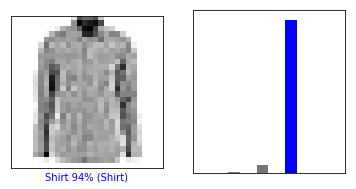

In [20]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)

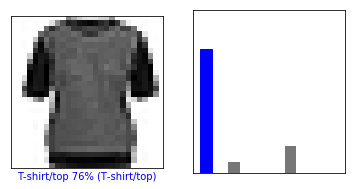

In [21]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)

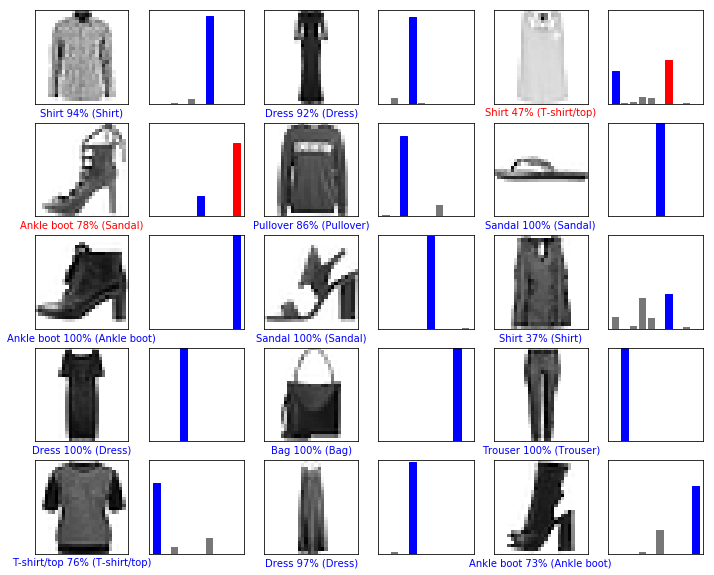

In [22]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)


단일 image에 대해 분류 예측을 해본다.

In [23]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28, 1)


이미지 1개를 batch로 만들어 예측을 할 수도 있다.

In [24]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


In [25]:
predictions_single = model.predict(img)

print(predictions_single)

[[1.3287648e-03 6.6508765e-05 5.5096024e-03 4.0732505e-04 5.0226174e-02
  1.2622776e-05 9.4219679e-01 3.3560841e-06 2.3487813e-04 1.3882697e-05]]


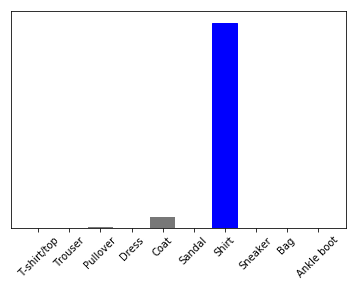

In [26]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

`model.predict` 는 list 의 lists로 리턴한다. 예측 확률이 제일 높은 것이 예측 클래스이다.

In [27]:
np.argmax(predictions_single[0])

6

# Exercises

다음과 같은 실습을 수행해 보자:

*   training epoch의 횟수를 적절히 조정하여 정확도가 어떻게 달라지는가?
*   첫번째 Dense layer의 hidden unit의 수를 10으로 변경했을때 정확도는 어떻게 달라지는가?
*   첫번째 Dense layer의 hidden unit의 수를 512로 변경했을때 정확도는 어떻게 달라지는가?
*   마지막 dense layer 전에 Dense layer를 하나 더 추가해 보시오. 이때 정확도는 어떻게 달라지는가?
*   normalize를 수행하지 않는다면 결과가 어떻게 되는지 확인해 보시오.
